In [1]:
import pandas as pd
import os
from project.dataset import Dataset, VALDODataset
from project.preprocessing import z_score_normalization, min_max_normalization, NiftiToTensorTransform, get_transform
# from project.preprocessing import z_score_normalization, min_max_normalization
# from project.training import split_train_val_datasets
from project.utils import collate_fn, plot_all_slices, plot_all_slices_from_array, collatev2, compute_statistics
from torch.utils.data import DataLoader
import torch
from project.model import VisionTransformer, ISAVIT
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from project.model.feeder import Feeder
import seaborn as sns
from project.evaluation import isa_vit_metric, Tracker

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tk = Tracker()

In [3]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
os.makedirs('history', exist_ok=True)
rn = dtt.now()
dte = rn.strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('andy')
fh = logging.FileHandler(f'logs/{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

tk.date = rn
tk.logfile = f'{dte}.log'

dte

'Nov_17_2024_133810'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tk.device = device
device

'cuda'

### Config for fitter

In [5]:
image_size = 300
patch_size = 64

config = {
    'model': ISAVIT(
        d_model=512,
        patch_size=patch_size,
        dim_ff=2500
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 20,
    'loss': nn.BCEWithLogitsLoss(),
    # 'loss': nn.MSELoss(),
    'lr': 0.001
}

tk.model = 'ViT'
tk.model_hyperparams = config['model'].config
tk.optimizer = f"{config['optimizer']}"
tk.epochs = config['epochs']
tk.loss = f"{config['loss']}"
tk.lr = config['lr']

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Create Stage 1 Network

In [7]:
from project.model import Feeder, RPN, GCRPN

resize = get_transform(
    height=patch_size,
    width=patch_size,
    p=1.0,
    rpn_mode=False
)

feeder = Feeder(resize)
rpn = RPN(
    input_dim=512,
    output_dim=4,
    image_size=image_size,
    nh=4
)

tk.uses_resnet = rpn.config['resnet']

stone = GCRPN(
    rpn=rpn,
    feeder=feeder,
    image_size=image_size,
    patch_size=patch_size
).to(device)

324


In [8]:
stow = 'RPN_test15_weights_Nov_02_2024_192506.pt'
# tk.stage1_weights = stow
stone.rpn.load_state_dict(torch.load(stow))

<All keys matched successfully>

#### Load ViT Weights

### Load dataset

In [9]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 7)

In [10]:
# data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
tk.only_cmb_slices = False
data

feed_data = data[(data.cohort == 1) | (data.cohort == 3)]

In [11]:
feedset = VALDODataset(
    cases=feed_data.mri.tolist(),
    masks=feed_data.masks.tolist(),
    target=feed_data.target.tolist(),
    transform=NiftiToTensorTransform(target_shape = (300, 300), rpn_mode=True),
)

### `DataLoader` Generator

In [12]:
def iqr(data, col):
    q3 = data[col].quantile(0.75)
    q1 = data[col].quantile(0.25)
    iqr = q3-q1
    new = data[(data[col] < (q3 + 1.5*iqr)) & (data[col] > (q1 - 1.5*iqr))]
    return new

In [ ]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 batch_size,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None,
                 tracker=tk
                ):
    if cohort == 1:
        tracker.cohort1 = True
    if cohort == 2:
        tracker.cohort2 = True
    if cohort == 3:
        tracker.cohort3 = True
    tracker.batch_size = batch_size
    tracker.test_size = test_size
    tracker.target_shape = target_shape
    data = data[data.cohort == cohort]
    # data = iqr(data, 'max_value')
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.mri.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.mri.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.mri.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    train_loader = DataLoader(
        train_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )
    val_loader = DataLoader(
        val_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_loader, val_loader

### Fitter

In [14]:
from project import Fitter

class ViTFitter(Fitter):
    
    def fit(self, train_loader, val_loader, stage1):
        train_history = []
        val_history = []
        train_metric_history = []
        val_metric_history = []
        for epoch in range(self.epochs):
            self.log(f'EPOCH {epoch} ==============================')
            train_loss, train_metric = self.train_one_epoch(train_loader, stage1)
            val_loss, val_metric = self.validation(val_loader, stage1)
            train_history.append(train_loss)
            val_history.append(val_loss)
            train_metric_history.append(train_metric)
            val_metric_history.append(val_metric)
        return train_history, val_history, train_metric_history, val_metric_history

    def train_one_epoch(self, train_loader, stage1):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                slices = slices.squeeze(1).float().to(self.device)
                masks = masks.float().to(self.device)

                # with torch.inference_mode():
                #     x, t = stage1(slices, masks, target)
                
                regions = feedset.locate_case_by_mri(case)
                bbox = regions[1][target].squeeze().round().int().tolist()

                x = feeder(slices, bbox, patch_size)
                t = feeder(masks, bbox, patch_size)

                x = x.flatten(2).float().to(self.device)
                t = t.flatten(2).float().to(self.device)
                # self.log(f'XT SHAPES: {x.shape}, {t.shape}')
                
                y = self.model(x, target)
                
                # print('Prediction:', (y.sigmoid() >= 0.5).int().unique())
                # print('Truth:', (t[target] >= 0).int().unique())

                dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), (t[target].squeeze().detach().cpu().numpy() > 0))

                evaluation_metric['dice_score'].append(dice_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                evaluation_metric['fpr'].append(fpr)
                # self.log(f'EVAL METS: {dice_score, precision_score, recall_score, f1_score, fpr}')

                Y.append(y)
                T.append(t[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric
    
    def validation(self, val_loader, stage1):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    slices = slices.squeeze(1).float().to(self.device)
                    masks = masks.float().to(self.device)
                    # x, t = stage1(slices, masks, target)
                    regions = feedset.locate_case_by_mri(case)
                    bbox = regions[1][target].squeeze().round().int().tolist()

                    x = feeder(slices, bbox, patch_size)
                    t = feeder(masks, bbox, patch_size)
                    x = x.flatten(2).float().to(self.device)
                    t = t.flatten(2).float().to(self.device)
                    y = self.model(x, target)

                    dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), (t[target].squeeze().detach().cpu().numpy() > 0))
                    evaluation_metric['dice_score'].append(dice_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    evaluation_metric['fpr'].append(fpr)
                    Y.append(y)
                    T.append(t[target])
                
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        
        self.log(f'\nValidations Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric

In [15]:
fitter = ViTFitter(config, logger=logger)

### Training

In [16]:
tl1, vl1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=False,
    batch_size=20
)

Creating loaders for Cohort 1
TRAIN & TEST: ((308, 7), (77, 7))
Total Unique MRI Samples in data_train: 11
GLOBAL MIN & MAX (0.0, 1417.92822265625)



In [17]:
tl3, vl3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=False,
    batch_size=20
)

Creating loaders for Cohort 3
TRAIN & TEST: ((858, 7), (215, 7))
Total Unique MRI Samples in data_train: 27
GLOBAL MIN & MAX (0.0, 664.0)



In [18]:
from torch.utils.data import ConcatDataset

train_set = ConcatDataset([tl1.dataset, tl3.dataset])
val_set = ConcatDataset([vl1.dataset, vl3.dataset])

In [19]:
tl = DataLoader(
    train_set,
    shuffle=True,
    batch_size=20,
    collate_fn=collatev2
)
vl = DataLoader(
    val_set,
    shuffle=True,
    batch_size=20,
    collate_fn=collatev2
)

In [20]:
thist, vhist, tmhist, vmhist = fitter.fit(tl, vl, stone)

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


In [21]:
import winsound

winsound.Beep(500, 500)

<Axes: >

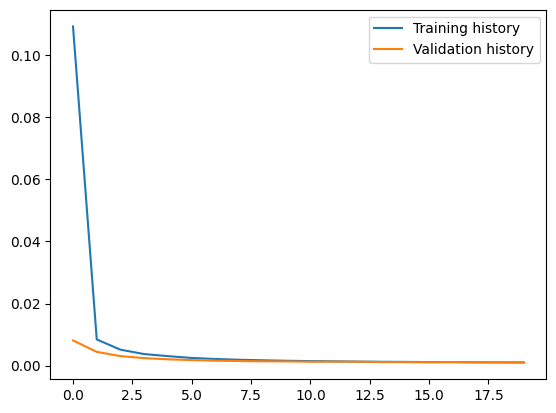

In [22]:
import seaborn as sns
import numpy as np

th = torch.tensor(np.array(thist))
vh = torch.tensor(np.array(vhist))
# print(th.shape)
sns.lineplot(th.mean(1), label='Training history')
sns.lineplot(vh.mean(1), label='Validation history')

In [23]:
sth = f'history/{dte}_thist.pt'
svh = f'history/{dte}_vhist.pt'
tk.saved_thist = sth
tk.saved_vhist = svh
torch.save(th, sth)
torch.save(vh, svh)

### Save The Weights

In [24]:
s = f'vit_weights_{dte}.pt'
s

'vit_weights_Nov_17_2024_133810.pt'

In [25]:
model = fitter.model
tk.saved_weights = s
torch.save(model.state_dict(), s)

### Evaluation

In [26]:
h, mh = fitter.validation(vl, stone)

In [27]:
valmets = pd.DataFrame(mh)
mets = valmets.mean()

In [28]:
tk.dice = mets.dice_score
tk.precision = mets.precision_score
tk.recall = mets.recall_score
tk.f1 = mets.f1_score
tk.fpr = mets.fpr

In [29]:
mets

dice_score         0.0
precision_score    0.0
recall_score       0.0
f1_score           0.0
fpr                0.0
dtype: float64

### Trial

In [30]:
sample = next(enumerate(tl))

In [31]:
case = sample[1][0]

In [32]:
slices, masks, target, path = case

<Axes: >

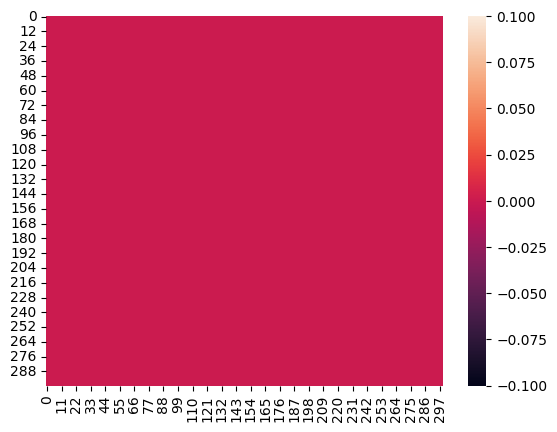

In [33]:
sns.heatmap(masks[target].squeeze())

In [34]:
slices = slices.squeeze(1).float().to(device)
masks = masks.float().to(device)

In [35]:
x, t = stone(slices, masks, target)

<Axes: title={'center': 'Mask Slice Crop'}>

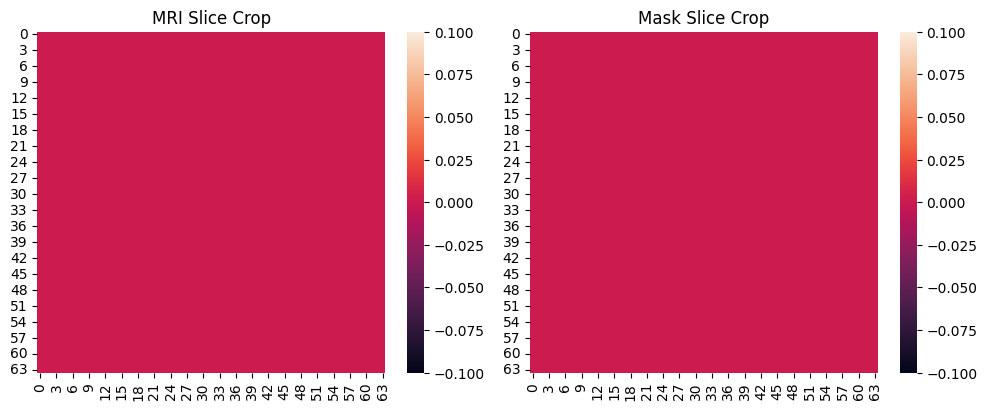

In [36]:
f, a = plt.subplots(1, 2, figsize=(10, 4))

f.tight_layout()
ax1 = a.flat[0]
ax2 = a.flat[1]
ax1.set_title('MRI Slice Crop')
ax2.set_title('Mask Slice Crop')
sns.heatmap(x[target].squeeze(), ax=ax1)
sns.heatmap(t[target].squeeze(), ax=ax2)

In [37]:
vit = config['model']

In [38]:
x.shape

torch.Size([35, 1, 64, 64])

In [39]:
y = vit(x.flatten(2).to(device), target)

In [40]:
y = y.view(patch_size, patch_size)

<Axes: title={'center': 'Mask Truth'}>

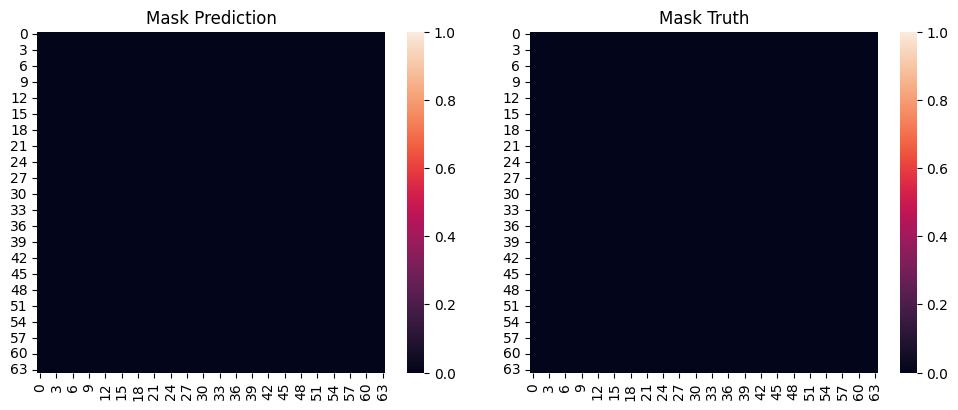

In [41]:
f, a = plt.subplots(1, 2, figsize=(10, 4))

f.tight_layout()
ax1 = a.flat[0]
ax2 = a.flat[1]
ax1.set_title('Mask Prediction')
ax2.set_title('Mask Truth')
sns.heatmap((y > 0.7).detach().cpu(), ax=ax1, vmax=1)
sns.heatmap(t[target].squeeze(), ax=ax2, vmax=1)

# Log Progress

In [42]:
tk.notes = '''
Added nn.Dropout(0.5, inplace=True) in SegmentationHead - Padded by 0 to perfect square - patch size 64
'''

In [43]:
tk()

,model,loaded_weights,stage1_weights,uses_resnet,only_cmb_slices,cohort1,cohort2,cohort3,optimizer,epochs,...,recall,f1,fpr,saved_weights,saved_thist,saved_vhist,model_hyperparams,logfile,device,notes
date,,,,,,,,,,,,,,,,,,,,,
2024-11-17 13:38:10.513578,ViT,None,None,False,False,True,False,True,<class 'torch.optim.adam.Adam'>,20,...,0.0,0.0,0.0,vit_weights_Nov_17_2024_133810.pt,history/Nov_17_2024_133810_thist.pt,history/Nov_17_2024_133810_vhist.pt,"{'d_model': 512, 'patch_size': 64, 'dim_ff': 2...",Nov_17_2024_133810.log,cuda,"\nAdded nn.Dropout(0.5, inplace=True) in Segme..."


In [44]:
if os.path.exists('history/runs.csv'):
    print('Merging to old df')
    prev_df = pd.read_csv('history/runs.csv', index_col='date')
    merged = pd.concat([prev_df, tk()])
    merged.to_csv('history/runs.csv')
else:
    print('Making new csv file')
    tk().to_csv('history/runs.csv')

Merging to old df
